# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Large-Scale-Distributed-Data-Science-using-Apache-Spark-2.2" data-toc-modified-id="Large-Scale-Distributed-Data-Science-using-Apache-Spark-2.2-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Large Scale Distributed Data Science using Apache Spark 2.2</a></div><div class="lev1 toc-item"><a href="#KMeans" data-toc-modified-id="KMeans-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>KMeans</a></div><div class="lev2 toc-item"><a href="#Data-Generation" data-toc-modified-id="Data-Generation-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Data Generation</a></div><div class="lev1 toc-item"><a href="#Data-Visualiazation" data-toc-modified-id="Data-Visualiazation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Visualiazation</a></div><div class="lev1 toc-item"><a href="#Set-enviroment-variable-for-PySpark" data-toc-modified-id="Set-enviroment-variable-for-PySpark-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Set enviroment variable for PySpark</a></div><div class="lev2 toc-item"><a href="#Distributed-KMeans-in-Spark" data-toc-modified-id="Distributed-KMeans-in-Spark-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Distributed KMeans in Spark</a></div><div class="lev1 toc-item"><a href="#MLlib-Kmeans" data-toc-modified-id="MLlib-Kmeans-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>MLlib Kmeans</a></div>

# Large Scale Distributed Data Science using Apache Spark 2.2

By James G. Shanahan1, 2 and Liang Dai1, 3 <P>
1 NativeX and iSchool, 2 UC Berkeley, CA, 3  UC Santa Cruz <P>

EMAIL: James_DOT_Shanahan_AT_gmail_DOT_com

# KMeans
## Data Generation

In [4]:
%matplotlib inline
import pylab 
import json
import numpy as np
import pandas as pd
import random
from IPython.display import display

In [5]:

size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')

# Data Visualiazation

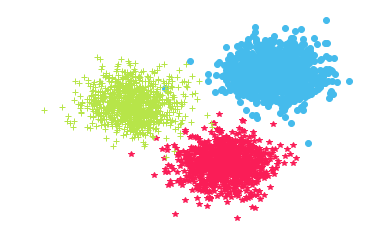

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(samples1[:, 0], samples1[:, 1],'*', color = '#fa1d57')
ax.plot(samples2[:, 0], samples2[:, 1],'o',color = '#45bbec')
ax.plot(samples3[:, 0], samples3[:, 1],'+',color = '#b7e549')
# fig.patch.set_visible(False)
ax.axis('off')
plt.show()

# Set enviroment variable for PySpark

In [7]:
'''
https://spark.apache.org/docs/latest/quick-start.html#self-contained-applications
There is an error in the example given ^^. builder is not executable

Only build a session if not on docker container (i.e. hostname in Docker is 'quickstart')
'''
from os import environ
try:
    host = environ['HOSTNAME']
except KeyError:
    host = 'not docker'

if host=='quickstart':
    pass
else:
    from pyspark.sql import SparkSession
    app_name = "kmeans"
    master = "local[*]"
    spark = SparkSession.builder.appName(app_name).master(master).getOrCreate()

In [8]:
# run this cell to get the correct link to the Spark UI
spark

In [18]:
import numpy as np

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(line[0]),float(line[1])])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    fig, ax = plt.subplots()
    colors = ['#edf6b2','#000000']
    ax.plot(samples1[:, 0], samples1[:, 1], '.', color = colors[0])
    ax.plot(samples2[:, 0], samples2[:, 1], '.', color = colors[0])
    ax.plot(samples3[:, 0], samples3[:, 1],'.', color = colors[0])
    ax.plot(means[0][0], means[0][1],'*',markersize =10,color = colors[1])
    ax.plot(means[1][0], means[1][1],'*',markersize =10,color = colors[1])
    ax.plot(means[2][0], means[2][1],'*',markersize =10,color = colors[1])
    ax.axis('off')
    plt.show()

## Distributed KMeans in Spark

In [19]:
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = spark.read.format("csv").load("./data.csv").rdd.cache()

# sanity checks:
print type(D)
print D.map(nearest_centroid).take(1)

<class 'pyspark.rdd.RDD'>
[(2, (array([ 6.35598805,  6.82189475]), 1))]


Iteration0
[[ 0.91393862  0.446028  ]
 [ 3.8881377   2.59269286]
 [ 2.22092753  5.74116557]]


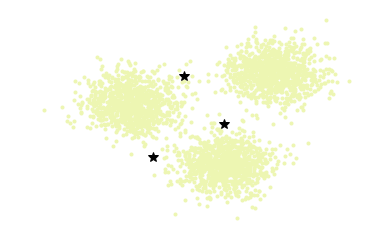

Iteration1
[[ 1.46599814  1.10191501]
 [ 5.13620157  2.20058546]
 [ 2.7593263   5.50029113]]


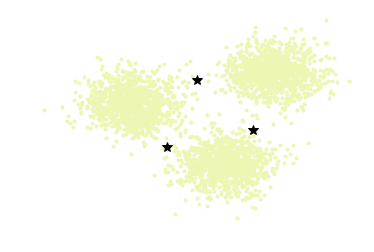

Iteration2
[[ 1.27077274  1.6398468 ]
 [ 5.29086949  1.82116748]
 [ 3.4762714   5.73135567]]


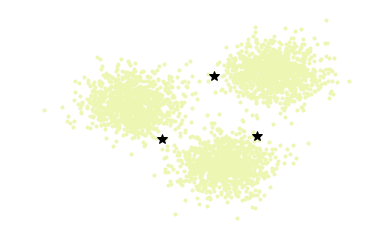

Iteration3
[[ 0.58895004  2.70440001]
 [ 4.68297216  0.56180959]
 [ 5.02310152  6.01667533]]


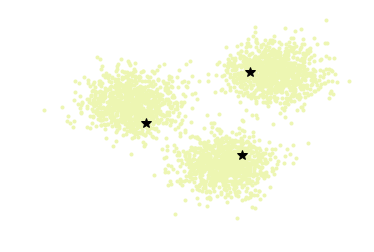

Iteration4
[[  1.55740088e-02   3.85252611e+00]
 [  4.00946480e+00   4.77886464e-03]
 [  5.97623481e+00   5.99417214e+00]]


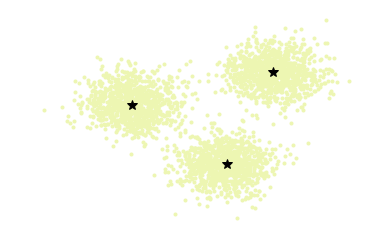

Iteration5
[[ -1.59294187e-03   3.94242710e+00]
 [  3.95003003e+00   7.53643823e-03]
 [  6.01689509e+00   5.98378404e+00]]


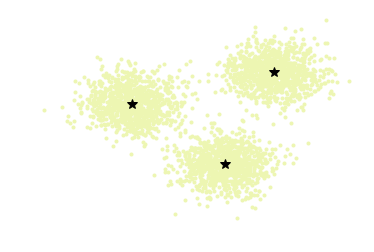

Iteration6
[[-0.00620259  3.94832433]
 [ 3.9456417   0.01486688]
 [ 6.02007093  5.98438321]]


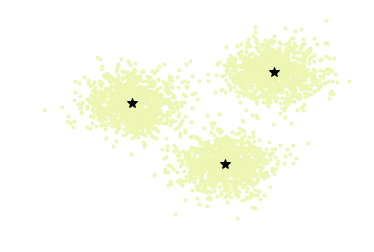

Final Results:
[[-0.00620259  3.94832433]
 [ 3.9456417   0.01486688]
 [ 6.02007093  5.98438321]]


In [20]:
iter_num = 0
for i in range(10):  
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    '''
    res [
        (0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)), 
        (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
        (1, (array([ 3986.85984761,    15.93153464]), 999))
        ]
    res[1][1][1] returns 1000 here
    '''
    
    res = sorted(res,key = lambda x : x[0])  # sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  # divide by cluster size
    if np.sum(np.absolute(centroids_new-centroids))<0.01:
        break
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1 
    centroids = centroids_new
    print centroids
    plot_iteration(centroids)
print "Final Results:"
print centroids

# MLlib Kmeans

http://spark.apache.org/docs/latest/mllib-clustering.html

In [54]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt

# Load and parse the data
data = spark.read.format("csv").load("./data.csv").rdd
parsedData = data.map(lambda line: array([float(line[0]),float(line[1])]))
parsedData.take(1)

[array([ 3.83773177, -0.79770583])]

In [55]:
# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 3, maxIterations=20,
        runs=10, initializationMode="random")
for centroid in clusters.centers:
    print centroid

[ 4.01504763 -0.00874997]
[ 6.0326483   6.00042014]
[ 0.05490624  4.0390827 ]
